# Retention Curves

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import seaborn as sns
sns.set_theme(style="white", palette='Greens_r', font='serif')

In [ ]:
df = pd.read_feather('/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/transactions.feather')

In [ ]:
df.columns

Index(['date_order', 'date_invoice', 'product_id', 'client_id', 'sales_net',
       'quantity', 'order_channel', 'branch_id', 'price', 'inv_is_order',
       'return', 'day', 'weekend', 'month', 'quarter', 'year', 'cohort'],
      dtype='object')

In [ ]:
df.drop(columns=['date_invoice', 'product_id', 'sales_net',
       'quantity', 'branch_id', 'price', 'inv_is_order'], inplace=True)

In [ ]:
df.head()

,date_order,client_id,order_channel,return,day,weekend,month,quarter,year,cohort
0,2017-09-25,188502,online,0,0,0,9,3,2017,20173
1,2017-09-25,835089,at the store,0,0,0,9,3,2017,20173
2,2017-09-25,1977896,online,0,0,0,9,3,2017,20173
3,2017-09-25,598816,at the store,0,0,0,9,3,2017,20173
4,2017-09-25,2086861,by phone,0,0,0,9,3,2017,20173


In [ ]:
# We don't use returns in this analysis
df = df[df['return']==0]

In [ ]:
df.head()

,date_order,client_id,order_channel,return,day,weekend,month,quarter,year,cohort
0,2017-09-25,188502,online,0,0,0,9,3,2017,20173
1,2017-09-25,835089,at the store,0,0,0,9,3,2017,20173
2,2017-09-25,1977896,online,0,0,0,9,3,2017,20173
3,2017-09-25,598816,at the store,0,0,0,9,3,2017,20173
4,2017-09-25,2086861,by phone,0,0,0,9,3,2017,20173


In [ ]:
client_df = df.groupby('client_id').agg(cohort=('cohort', 'min'), first_date=('date_order', 'min'), main_channel=('order_channel', lambda x: x.value_counts().index[0]))

In [ ]:
client_df.head()

,cohort,first_date,main_channel
client_id,,,
6,20174,2017-10-27,by phone
7,20183,2018-07-16,at the store
14,20173,2017-09-25,by phone
18,20173,2017-09-26,at the store
25,20184,2018-10-10,at the store


In [ ]:
# Only keep columns needed for the analysis
df = df.drop(columns=['cohort', 'day', 'weekend', 'month', 'year', 'quarter', 'return']).merge(client_df.reset_index(), on='client_id')

In [ ]:
df.tail()

,date_order,client_id,order_channel,cohort,first_date,main_channel
60934367,2019-07-08,403771,at the store,20193,2019-07-08,at the store
60934368,2019-09-12,410452,at the store,20193,2019-09-12,at the store
60934369,2019-03-01,751654,by phone,20191,2019-03-01,by phone
60934370,2018-02-01,1036972,by phone,20181,2018-02-01,by phone
60934371,2019-08-21,701328,at the store,20193,2019-08-21,at the store


In [ ]:
df = df.groupby(['client_id', 'date_order']).agg(cohort=('cohort', 'min'), first_date=('first_date', 'min'), main_channel=('main_channel', 'first'))
df.head()

cohort first_date main_channel
client_id date_order                                
6         2017-10-27   20174 2017-10-27     by phone
          2017-11-29   20174 2017-10-27     by phone
          2018-03-30   20174 2017-10-27     by phone
          2018-05-10   20174 2017-10-27     by phone
          2018-11-20   20174 2017-10-27     by phone

In [ ]:
df = df.reset_index()

In [ ]:
df['quarter_index'] = ((df['date_order'].dt.year - df['first_date'].dt.year)*4 + (df['date_order'].dt.quarter - df['first_date'].dt.quarter))
# subtract datetime objects, then retrieve the number of quarters

In [ ]:
df.head()

,client_id,date_order,cohort,first_date,main_channel,quarter_index
0,6,2017-10-27,20174,2017-10-27,by phone,0
1,6,2017-11-29,20174,2017-10-27,by phone,0
2,6,2018-03-30,20174,2017-10-27,by phone,1
3,6,2018-05-10,20174,2017-10-27,by phone,2
4,6,2018-11-20,20174,2017-10-27,by phone,4


In [ ]:
df['main_channel'].unique()

array(['by phone', 'at the store', 'other', 'online',
       'during the visit of a sales rep'], dtype=object)

In [ ]:
df_ret = df.groupby(['cohort', 'quarter_index'])['client_id'].nunique().reset_index()

In [ ]:
df_ret = df_ret.pivot(index='cohort', columns='quarter_index', values='client_id')

In [ ]:
# Number of clients per cohort that buy also in one of the following quarters
df_ret

quarter_index,0,1,2,3,4,5,6,7,8
cohort,,,,,,,,,
20173,39862.0,37931.0,36397.0,35227.0,35163.0,34273.0,33014.0,32362.0,32211.0
20174,65721.0,46647.0,43043.0,44102.0,42871.0,39221.0,37958.0,38520.0,NaN
20181,17430.0,8295.0,8469.0,7994.0,7203.0,6834.0,6973.0,NaN,NaN
20182,10060.0,4870.0,4279.0,3733.0,3684.0,3682.0,NaN,NaN,NaN
20183,10031.0,4497.0,3697.0,3451.0,3879.0,NaN,NaN,NaN,NaN
20184,9057.0,4550.0,3943.0,3986.0,NaN,NaN,NaN,NaN,NaN
20191,6748.0,3251.0,3008.0,NaN,NaN,NaN,NaN,NaN,NaN
20192,5554.0,2835.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20193,6126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Transform into percentages
df_ret_perc = df_ret.divide(df_ret[0], axis=0)
df_ret_perc

quarter_index,0,1,2,3,4,5,6,7,8
cohort,,,,,,,,,
20173,1.0,0.951558,0.913075,0.883724,0.882118,0.859791,0.828207,0.811851,0.808063
20174,1.0,0.709773,0.654935,0.671049,0.652318,0.596780,0.577563,0.586114,NaN
20181,1.0,0.475904,0.485886,0.458635,0.413253,0.392083,0.400057,NaN,NaN
20182,1.0,0.484095,0.425348,0.371074,0.366203,0.366004,NaN,NaN,NaN
20183,1.0,0.448310,0.368557,0.344033,0.386701,NaN,NaN,NaN,NaN
20184,1.0,0.502374,0.435354,0.440102,NaN,NaN,NaN,NaN,NaN
20191,1.0,0.481772,0.445762,NaN,NaN,NaN,NaN,NaN,NaN
20192,1.0,0.510443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20193,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Customer retention')

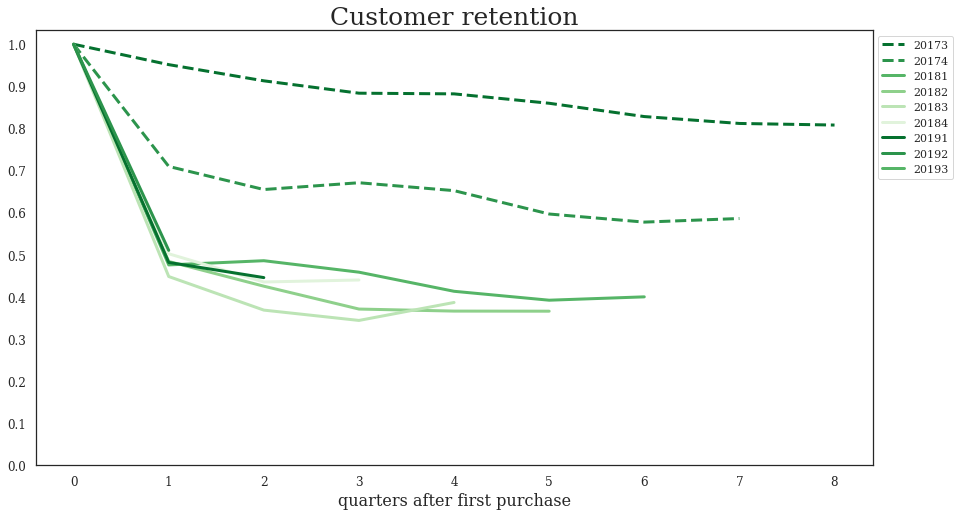

In [ ]:
# Visualize retention curves
fig, ax = plt.subplots(figsize=(15,8))
df_ret_perc[:2].T.iloc[:,:].plot(ax=ax, linestyle ='--', linewidth=3)
df_ret_perc[2:].T.iloc[:,:].plot(ax=ax, linewidth=3)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_yticks(list(np.linspace(0,1,11)))
ax.set_xlabel('quarters after first purchase', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('Customer retention', fontsize=25)

The first two cohorts will not be used in further analysis since they are strongly influenced by the fact that our dataset represents only a limited timeframe and recurring customers would be counted as new ones for the first couple of weeks.

In [ ]:
# Only look at clients that first purchased after Nov 2021 to limit the effect mentioned above
df_rel = df[(df['first_date'] > '2017-10-31')]

In [ ]:
# Create a dataframe per channel
dfs = {}
dfs['All channels'] = df_rel
for key in df_rel['main_channel'].unique():
  dfs[key] = df_rel[df_rel['main_channel'] == key]

In [ ]:
for channel in dfs.keys():
  dfs[channel] = dfs[channel].groupby(['cohort', 'quarter_index'])['client_id'].nunique().reset_index()
  dfs[channel] = dfs[channel].pivot(index='cohort', columns='quarter_index', values='client_id')
  dfs[channel] = dfs[channel].divide(dfs[channel][0], axis=0)

In [ ]:
dfs['other']

quarter_index,0,1,2,3,4,5,6,7
cohort,,,,,,,,
20174,1.0,0.333333,0.333333,0.366667,0.600000,0.300000,0.233333,0.233333
20181,1.0,0.119565,0.206522,0.130435,0.293478,0.108696,0.119565,NaN
20182,1.0,0.090909,0.090909,0.181818,0.727273,0.136364,NaN,NaN
20183,1.0,0.086957,0.108696,0.130435,0.717391,NaN,NaN,NaN
20184,1.0,0.388889,0.722222,0.611111,NaN,NaN,NaN,NaN
20191,1.0,0.750000,0.500000,NaN,NaN,NaN,NaN,NaN
20192,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
20193,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


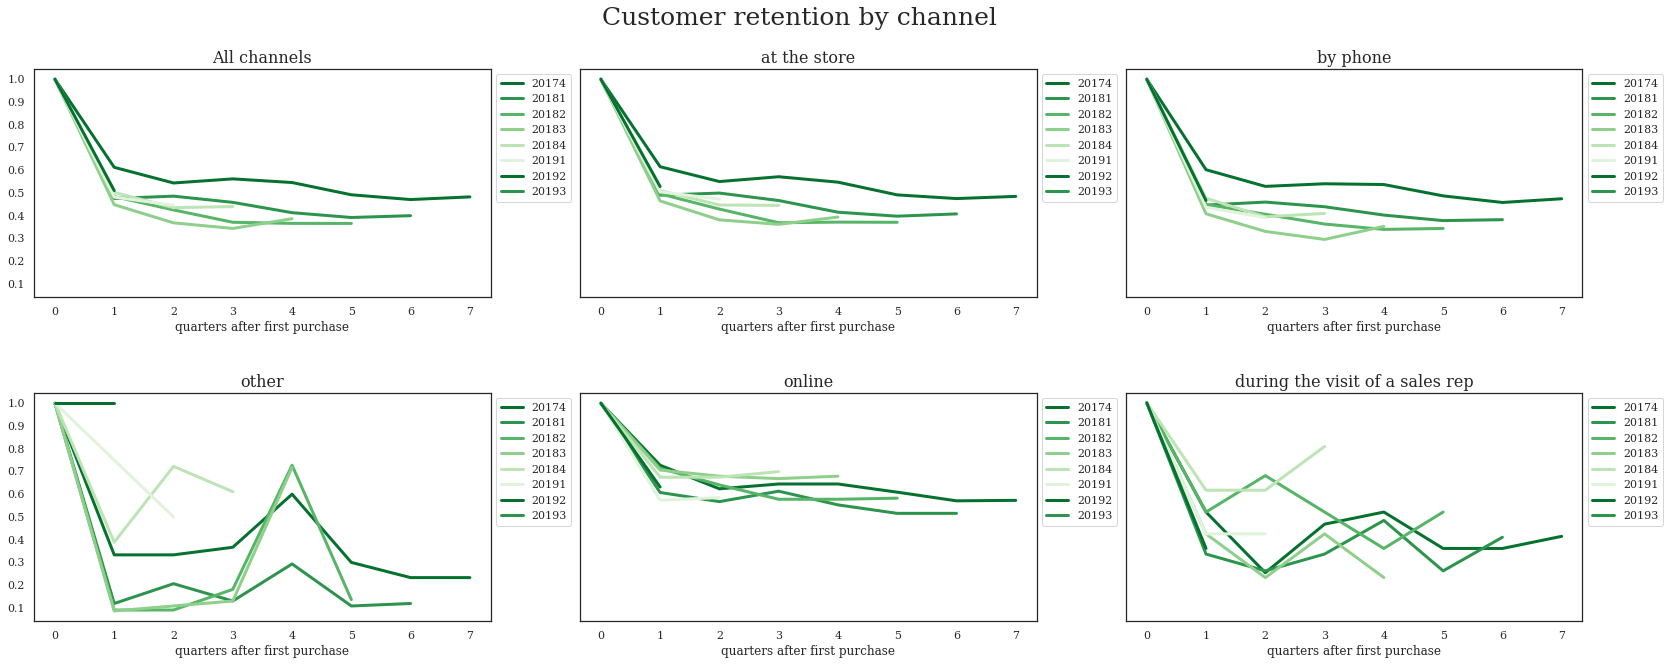

In [ ]:
# Visualize the retention rate per channel
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(24,10), sharey=True)
fig.tight_layout(pad=6)
fig.suptitle('Customer retention by channel', fontsize=25)
for channel, ax in zip(dfs.keys(), axes.ravel()):
  dfs[channel].T.plot(ax=ax, linewidth=3)
  ax.legend(bbox_to_anchor=(1,1), loc="upper left")
  ax.set_yticks(list(np.linspace(0,1,11)))
  ax.set_xlabel('quarters after first purchase')
  ax.set_title(channel, fontsize=16)

In [ ]:
# Show the average retention rate after the first year per channel
# This value will later be used in other analyses
for key in dfs.keys():
  print(f'{key}: {round(dfs[key].iloc[:,3].mean(),3)}')

All channels: 0.435
at the store: 0.443
by phone: 0.41
other: 0.284
online: 0.641
during the visit of a sales rep: 0.49
